# Application for the More Electric Aircraft (MEA) conference

This document has been published for reproducing the application presented in the 2024 [More Electric Aircraft Conference](https://conference-mea.org/). The code and results are given in the following.

The objective is to estimate the impact of electric, hybrid-electric and hydrogen aircraft on aviation CO<sub>2</sub> emissions and energy consumption. It is the first application which includes the use of electric and hybrid-electric architectures in the AeroMAPS fleet model.

> **⚠ This notebook has been developed with the AeroMAPS version v0.6.1-beta for obtaining the paper results. However, this notebook has been or could be modified in order to be executable with the latest versions of AeroMAPS, which sometimes leads to different results compared to the ones from the paper, due to some models' modifications. In order to retrieve the results of the paper, one can use the v0.6.1-beta version associated with the original notebook.**

## Load and process

In [1]:
%matplotlib widget
from pathlib import Path
from pandas import read_csv
import matplotlib.pyplot as plt
from aeromaps import create_process
from aeromaps.core.models import (
    models_traffic,
    models_efficiency_bottom_up,
    models_energy_without_fuel_effect,
    models_offset,
    models_climate_simple_gwpstar,
    models_sustainability,
    models_energy_cost,
    models_operation_cost_bottom_up,
    models_production_cost,
    models_abatements_cost,
)

In [2]:
models = {
    "models_traffic": models_traffic,
    "models_efficiency_bottom_up": models_efficiency_bottom_up,
    "models_energy_without_fuel_effect": models_energy_without_fuel_effect,
    "models_energy_cost": models_energy_cost,
    "models_offset": models_offset,
    "models_climate_simple_gwpstar": models_climate_simple_gwpstar,
    "models_sustainability": models_sustainability,
}

## Scenario settings
Select the scenario before creating the process. Fleet assumptions are now driven by dedicated YAML files, so changing `SCENARIO` requires re-running the process creation cell.

In [3]:
# Scenario controls
SCENARIO = "Mix"  # Choose between "Others" and "Mix"

# Settings for sensitivity analyses
DROP_IN_FUEL = "Kerosene"  # Choose between "Kerosene" and "ReFuelEU"
ELECTRICITY = "Dedicated"  # Choose between "Dedicated", "Linear transition" and "Accelerated transition"

In [4]:
CONFIG_PATHS = {
    "Mix": Path("data/config_mix.json"),
    "Others": Path("data/config_others.json"),
}
selected_config = CONFIG_PATHS.get(SCENARIO, CONFIG_PATHS["Mix"]).resolve()

process = create_process(
    custom_models=models,
    configuration_file=str(selected_config),
 )

In [5]:
# Change end year
process.parameters.end_year = 2060
process.common_setup()
process.setup_mda()

### Fleet configuration
Fleet categories, subcategories, shares, and aircraft characteristics are now fully defined by the YAML files referenced in the configuration. No additional manual fleet edits are required in the notebook.

/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/air_transport/aircraft_fleet_and_operations/fleet/fleet_model.py:1611: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df.loc[k, category.name + ":doc_non_energy"] = (
/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/air_transport/aircraft_fleet_and_operations/fleet/fleet_model.py:1611: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df.loc[k, category.name + ":doc_non_energy"] = (


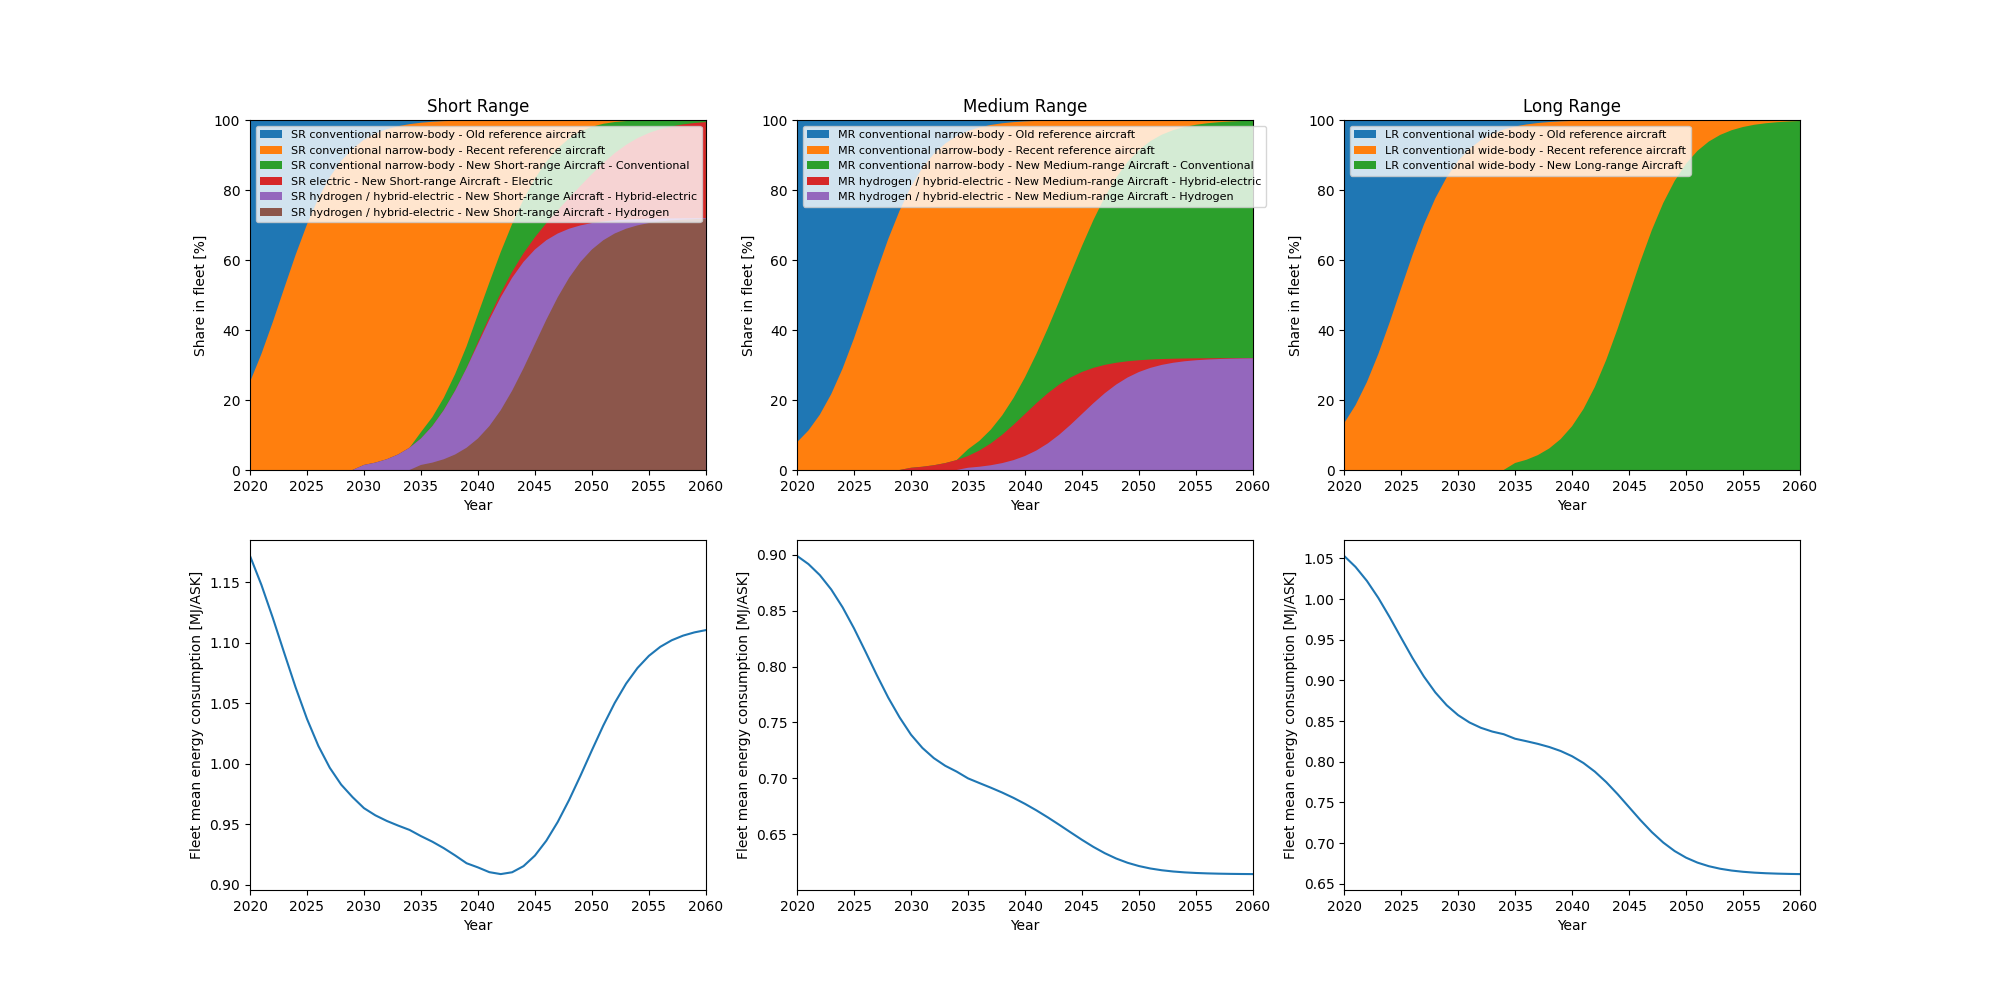

In [6]:
fleet_model = process.fleet_model
fleet_model.compute()
fleet_model.plot()

In [7]:
# Aircraft energy - Introduction of alternative drop-in fuels

# Modified for the generic energy model, though not used in the model's philosophy

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
if DROP_IN_FUEL == "Kerosene":
    process.parameters.hefa_fog_mandate_share_years = []
    process.parameters.hefa_fog_mandate_share_values = [0]
    process.parameters.hefa_others_mandate_share_years = []
    process.parameters.hefa_others_mandate_share_values = [0]
    process.parameters.ft_others_mandate_share_years = []
    process.parameters.ft_others_mandate_share_values = [0]
    process.parameters.ft_msw_mandate_share_years = []
    process.parameters.ft_msw_mandate_share_values = [0]
    process.parameters.atj_mandate_share_years = []
    process.parameters.atj_mandate_share_values = [0]
    process.parameters.electrofuel_mandate_share_years = []
    process.parameters.electrofuel_mandate_share_values = [0]


elif DROP_IN_FUEL == "ReFuelEU":
    process.parameters.hefa_fog_mandate_share_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.hefa_fog_mandate_share_values = [0.0, 0.0336, 0.168, 0.245, 0.28]
    process.parameters.hefa_others_mandate_share_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.hefa_others_mandate_share_values = [0.0, 0.1824, 0.912, 1.33, 1.52]
    process.parameters.ft_others_mandate_share_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.ft_others_mandate_share_values = [0.0, 3.6624, 18.312, 26.705, 30.52]
    process.parameters.ft_msw_mandate_share_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.ft_msw_mandate_share_values = [0.0, 0.3552, 1.776, 2.59, 2.96]
    process.parameters.atj_mandate_share_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.atj_mandate_share_values = [0.0, 0.5664, 2.832, 4.13, 4.72]
    process.parameters.electrofuel_mandate_share_years = [2020, 2030, 2040, 2050, 2060]
    process.parameters.electrofuel_mandate_share_values = [0.0, 1.2, 10.0, 35.0, 60.0]

In [8]:
# Various environmental settings

## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
## Assumption of a current use of HEFA FOG and an equal distribution from 2030 according to biomass resources distribution
# process.parameters.biofuel_hefa_fog_share_reference_years = [2020, 2030, 2060]
# process.parameters.biofuel_hefa_fog_share_reference_years_values = [100, 0.7, 0.7]
# process.parameters.biofuel_hefa_others_share_reference_years = [2020, 2030, 2060]
# process.parameters.biofuel_hefa_others_share_reference_years_values = [0.0, 3.8, 3.8]
# process.parameters.biofuel_ft_others_share_reference_years = [2020, 2030, 2060]
# process.parameters.biofuel_ft_others_share_reference_years_values = [0.0, 76.3, 76.3]
# process.parameters.biofuel_ft_msw_share_reference_years = [2020, 2030, 2060]
# process.parameters.biofuel_ft_msw_share_reference_years_values = [0.0, 7.4, 7.4]

## Emission factors for electricity (2019 value: 429 gCO2/kWh)
# if ELECTRICITY == "Dedicated":
#     process.parameters.electricity_emission_factor_reference_years = []
#     process.parameters.electricity_emission_factor_reference_years_values = [10.0]
# elif ELECTRICITY == "Linear transition":
#     process.parameters.electricity_emission_factor_reference_years = [2020, 2060]
#     process.parameters.electricity_emission_factor_reference_years_values = [429.0, 10.0]
# elif ELECTRICITY == "Accelerated transition":  # Division by 2.5 per decade
#     process.parameters.electricity_emission_factor_reference_years = [2020, 2030, 2040, 2050, 2060]
#     process.parameters.electricity_emission_factor_reference_years_values = [
#         429.0,
#         170.0,
#         70.0,
#         25.0,
#         10.0,
#     ]

# --> Update for generic models

if ELECTRICITY == "Dedicated":
    process.parameters.generic_electricity_co2_emission_factor_years = []
    process.parameters.generic_electricity_co2_emission_factor_values = [10.0]
elif ELECTRICITY == "Linear transition":
    process.parameters.generic_electricity_co2_emission_factor_years = [2020, 2060]
    process.parameters.generic_electricity_co2_emission_factor_values = [429.0, 10.0]
elif ELECTRICITY == "Accelerated transition":  # Division by 2.5 per decade
    process.parameters.generic_electricity_co2_emission_factor_years = [
        2020,
        2030,
        2040,
        2050,
        2060,
    ]
    process.parameters.generic_electricity_co2_emission_factor_values = [
        429.0,
        170.0,
        70.0,
        25.0,
        10.0,
    ]

## Share of hydrogen production pathways (the rest being completed by production via coal without CCS) [%]
## Distribution in 2019: Gas without CCS (71%), Coal without CCS (27%), Electrolysis (2%), Others with CCS (0%), Co-products not taken into account
## Assumption of a dedicated use of electrolysis pathway here
# process.parameters.hydrogen_electrolysis_share_reference_years = []
# process.parameters.hydrogen_electrolysis_share_reference_years_values = [100]
# process.parameters.hydrogen_gas_ccs_share_reference_years = []
# process.parameters.hydrogen_gas_ccs_share_reference_years_values = [0]
# process.parameters.hydrogen_coal_ccs_share_reference_years = []
# process.parameters.hydrogen_coal_ccs_share_reference_years_values = [0]
# process.parameters.hydrogen_gas_share_reference_years = []
# process.parameters.hydrogen_gas_share_reference_years_values = [0]

# --> Update Generic models: electrolysis used as default hydrogen production pathway

In [9]:
# Other settings

## Air traffic evolution - Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [3.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [3.0]

## Aircraft fleet and operation evolution - Aircraft load factor
process.parameters.load_factor_end_year = 89.0  # 2019 value: 82.399312

# Aircraft fleet and operation evolution - Operations
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## Compute

In [10]:
process.compute()

/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/air_transport/aircraft_fleet_and_operations/fleet/fleet_model.py:1611: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df.loc[k, category.name + ":doc_non_energy"] = (
/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/air_transport/aircraft_fleet_and_operations/fleet/fleet_model.py:1611: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df.loc[k, category.name + ":doc_non_energy"] = (
/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/yaml_interpolator.py:

Running MDA


/Users/s.delbecq/VSCodeProjects/AeroMAPS/aeromaps/models/base.py:155: UserWarning: Warning Message - Model name: exogenous_carbon_price_trajectory - Warning on aeromaps_interpolation_function: The last reference year for the interpolation is lower than end_year, the value associated to the last reference year is therefore used as a constant for the upper years.
  warnings.warn(


## Results

The following results are those obtained for the scenario set previously.

In [11]:
print(
    "CO2 emissions in 2050:",
    round(process.data["climate_outputs"]["co2_emissions"][2050], 0),
    "MtCO2",
)
print(
    "Cumulative CO2 emissions between 2020 and 2050:",
    round(process.data["vector_outputs"]["cumulative_co2_emissions"][2050], 1),
    "GtCO2",
)
print(
    "Energy consumption in 2050:",
    round(process.data["vector_outputs"]["energy_consumption"][2050] / 10**12, 1),
    "EJ",
)
print(
    "CO2 emissions in 2060:",
    round(process.data["climate_outputs"]["co2_emissions"][2060], 0),
    "MtCO2",
)

CO2 emissions in 2050: 1038.0 MtCO2
Cumulative CO2 emissions between 2020 and 2050: 32.3 GtCO2
Energy consumption in 2050: 17.3 EJ
CO2 emissions in 2060: 1259.0 MtCO2


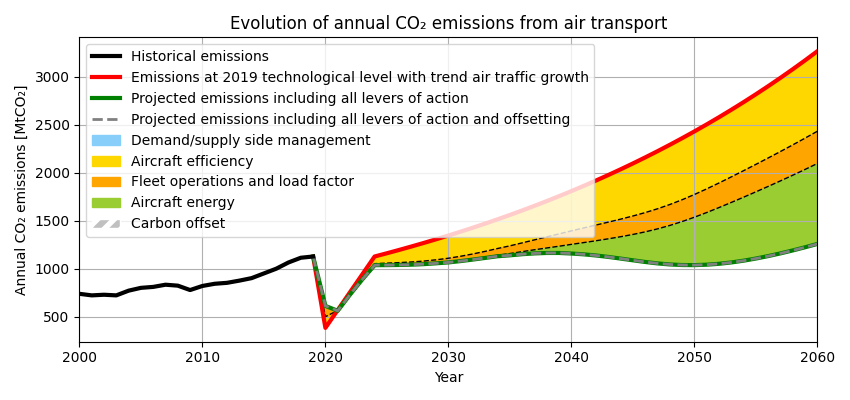

In [12]:
process.plot("air_transport_co2_emissions")

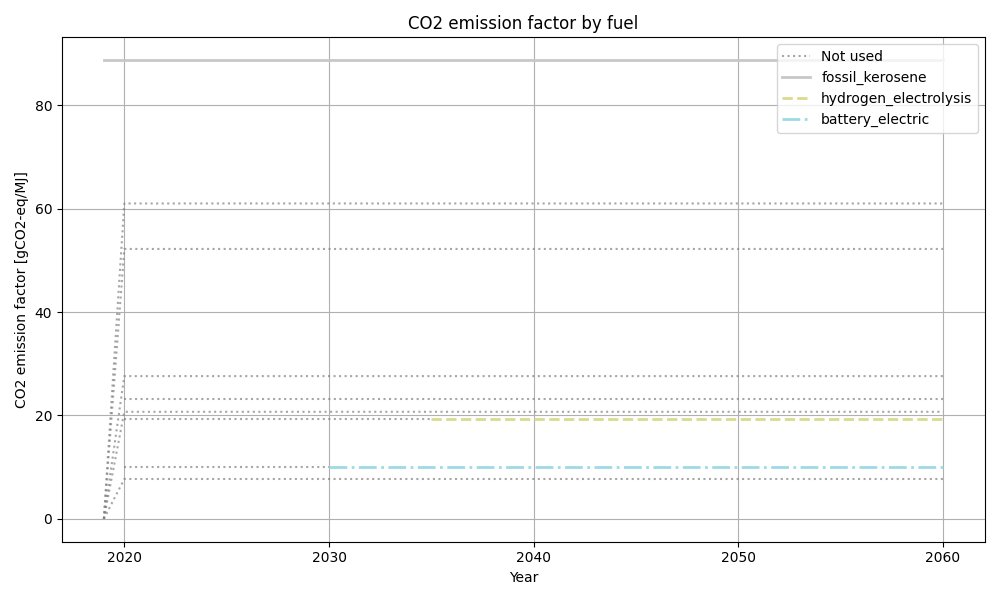

In [13]:
process.plot("emission_factor_per_fuel")

# All results

This part includes the main plots of the paper, summarizing the different scenarios and sensitivity analyses. The scenarios data have been stored on csv files.

## Baseline scenarios

In [14]:
mea_data_df = read_csv("data/mea_data.csv", delimiter=";")
mea_data = mea_data_df.values
mea_data_reference = mea_data[:, 1]
mea_data_electric = mea_data[:, 2]
mea_data_electric_low = mea_data[:, 3]
mea_data_electric_high = mea_data[:, 4]
mea_data_hybridelectric = mea_data[:, 5]
mea_data_hybridelectric_low = mea_data[:, 6]
mea_data_hybridelectric_high = mea_data[:, 7]
mea_data_hydrogen = mea_data[:, 8]
mea_data_hydrogen_low = mea_data[:, 9]
mea_data_hydrogen_high = mea_data[:, 10]
mea_data_mix = mea_data[:, 11]

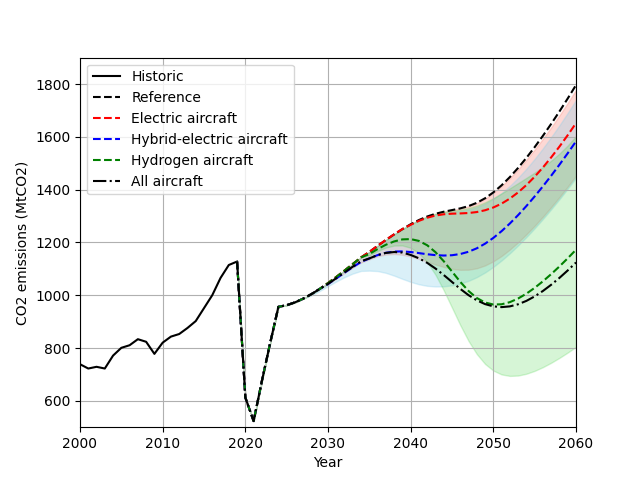

In [15]:
data_years_total = list(range(1940, 2101))

fig, ax = plt.subplots()
ax.plot(
    process.data["years"]["historic_years"],
    process.data["climate_outputs"]["co2_emissions"][2000 - 1940 : 2000 - 1940 + 20],
    color="black",
    label="Historic",
    linestyle="-",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_reference[0:42],
    color="black",
    label="Reference",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electric[0:42],
    color="red",
    label="Electric aircraft",
    linestyle="--",
)
ax.fill_between(
    process.data["years"]["prospective_years"],
    mea_data_electric_low[0:42],
    mea_data_electric_high[0:42],
    color="salmon",
    alpha=0.3,
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_hybridelectric[0:42],
    color="blue",
    label="Hybrid-electric aircraft",
    linestyle="--",
)
ax.fill_between(
    process.data["years"]["prospective_years"],
    mea_data_hybridelectric_low[0:42],
    mea_data_hybridelectric_high[0:42],
    color="skyblue",
    alpha=0.3,
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_hydrogen[0:42],
    color="green",
    label="Hydrogen aircraft",
    linestyle="--",
)
ax.fill_between(
    process.data["years"]["prospective_years"],
    mea_data_hydrogen_low[0:42],
    mea_data_hydrogen_high[0:42],
    color="limegreen",
    alpha=0.2,
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_mix[0:42],
    color="black",
    label="All aircraft",
    linestyle="-.",
)

ax.set(
    xlabel="Year",
    ylabel="CO2 emissions (MtCO2)",
)
ax.grid()
plt.xlim(2000, 2060)
plt.ylim(500, 1900)
plt.legend()
plt.show()

## Sensitivity to electricity emission factor

In [16]:
mea_data_electricity_df = read_csv("data/mea_data_electricity.csv", delimiter=";")
mea_data_electricity = mea_data_electricity_df.values
mea_data_electricity_electric = mea_data_electricity[:, 1]
mea_data_electricity_hybridelectric = mea_data_electricity[:, 2]
mea_data_electricity_hydrogen = mea_data_electricity[:, 3]
mea_data_electricity_mix = mea_data_electricity[:, 4]

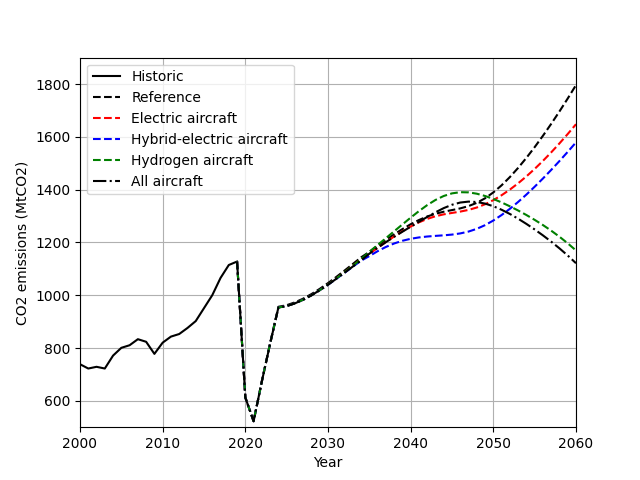

In [17]:
fig, ax = plt.subplots()
ax.plot(
    process.data["years"]["historic_years"],
    process.data["climate_outputs"]["co2_emissions"][2000 - 1940 : 2000 - 1940 + 20],
    color="black",
    label="Historic",
    linestyle="-",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_reference[0:42],
    color="black",
    label="Reference",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electricity_electric,
    color="red",
    label="Electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electricity_hybridelectric,
    color="blue",
    label="Hybrid-electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electricity_hydrogen,
    color="green",
    label="Hydrogen aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_electricity_mix,
    color="black",
    label="All aircraft",
    linestyle="-.",
)

ax.set(
    xlabel="Year",
    ylabel="CO2 emissions (MtCO2)",
)
ax.grid()
plt.xlim(2000, 2060)
plt.ylim(500, 1900)
plt.legend()
plt.show()

## Sensitivity to ReFuelEU

In [18]:
mea_data_refueleu_df = read_csv("data/mea_data_refueleu.csv", delimiter=";")
mea_data_refueleu = mea_data_refueleu_df.values
mea_data_refueleu_reference = mea_data_refueleu[:, 1]
mea_data_refueleu_electric = mea_data_refueleu[:, 2]
mea_data_refueleu_hybridelectric = mea_data_refueleu[:, 3]
mea_data_refueleu_hydrogen = mea_data_refueleu[:, 4]
mea_data_refueleu_mix = mea_data_refueleu[:, 5]

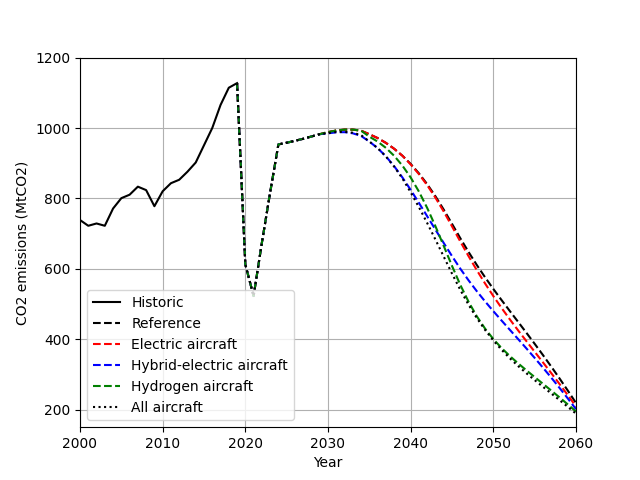

In [19]:
fig, ax = plt.subplots()
ax.plot(
    process.data["years"]["historic_years"],
    process.data["climate_outputs"]["co2_emissions"][2000 - 1940 : 2000 - 1940 + 20],
    color="black",
    label="Historic",
    linestyle="-",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_reference,
    color="black",
    label="Reference",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_electric,
    color="red",
    label="Electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_hybridelectric,
    color="blue",
    label="Hybrid-electric aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_hydrogen,
    color="green",
    label="Hydrogen aircraft",
    linestyle="--",
)

ax.plot(
    process.data["years"]["prospective_years"],
    mea_data_refueleu_mix,
    color="black",
    label="All aircraft",
    linestyle=":",
)

ax.set(
    xlabel="Year",
    ylabel="CO2 emissions (MtCO2)",
)
ax.grid()
plt.xlim(2000, 2060)
plt.ylim(150, 1200)
plt.legend()
plt.show()

In [20]:
from aeromaps.utils.functions import clean_notebooks_on_tests

clean_notebooks_on_tests(globals())